# Linear regression and Regularization

*  [0) Prerequisites](#pr)
*  [1) Linear Regression](#lin)
*  [2) Regularization](#reg)

<a id="pr"></a>
## 0. Prerequisites

### Dealing with missing values: <br/>
[`sklearn.impute`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute)

### Работа с категориальными признаками


Большинство алгоритмов не принимает категориальные фичи в чистом виде и нужно из как-то закодировать.

Очень небольшое число алгоритмов МО умеет работать с категориальными признаками в чистом виде. Например, это делает библиотека для градиентного бустинга от Яндекса catboost. Внтури она применяет разные эвристики для кодирования признаков в числа.1

#### One-hot-encoding
Самый простой способ закодировать категориальные фичи - one hot encoding. 
В pandas очень удобно использовать get_dummies для one-hot-encoding

In [1]:
from sklearn.datasets import load_breast_cancer 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
cancer = load_breast_cancer()
df = pd.DataFrame(data=np.hstack([cancer.data, cancer.target[:, np.newaxis]]), 
                 columns = np.append(cancer.feature_names,'target'))

In [3]:
df1 = pd.get_dummies(df, columns = ['target'])

In [4]:
# one-hot coding for categorical variables, by default it's applied to all columns
from sklearn.preprocessing import OneHotEncoder
# for using OneHotEncoder only to specific columns
from sklearn.compose import ColumnTransformer 
ohe = ColumnTransformer([('One Hot', OneHotEncoder(sparse = False), [1])], remainder = 'passthrough')

### Масштабирование признаков

Необходимо привести все признаки к одному масштабу. Для этого в sklearn есть специальный Transformer -- StandardScaler и MinMaxScaler.

StandardScaler во время .fit() для каждого признака $x_i$ считает среднее $\mu_i$ и стандартное отклонение $\sigma_i$ на обучающем датасете. Во время .transform() к каждому признаку применяется:

$$\mathbf{x_i}^{\text{new}} = \frac{\mathbf{x_i} - \mu_i}{\sigma_i}$$


MinMaxScaler во время .fit() для каждого признака $x_i$ считает минимум $x_{i, \text{min}}$ и максимум $x_{i, \text{max}}$ на обучающем датасете. Во время .transform() к каждому признаку применяется:

$$\mathbf{x_i}^{\text{new}} = \frac{\mathbf{x_i} - x_{i, \text{min}}}{x_{i, \text{max}} - x_{i, \text{min}}}$$

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

pca = StandardScaler()
pca.fit(df)
# Выход pca - numpy матрица, положим ее в новую переменную со всеми фичами
X = pca.transform(df)

# Или есть более простой способ 
X = pca.fit_transform(df)

## Разделение на train/test

Чтобы бороться с переобучением обучающую выборку обычно делят на две части train и test. На первой мы будем обучать модель, а на второй проверять, насколько хорошо модель работает. Размер тестовой выборки в 30-40% - неплохой выбор.

Иногда данных слишком мало, чтобы жертвовать ими на тестовую часть. Тогда применяется метод, который называет cross validation. Мы посмотрим на то, как он работает в секции про оценку модели.

**На самом деле, мы сделали не совсем правильно, потому что разделение на train/test нужно делать до добавления новых фичей/их кодирования итд. Иначе возможны лики из test части в train часть.** Например, при нормализации и PCA мы работаем со всем массивом данных, а значит информация из test попадет и в train. Но для упрощения кода и понимания того, что происходит мы не поделили выборку заранее. Если бы мы все-таки разделили выборку заранее, то нужно использовать fit на train части, а transform уже на обеих.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, df['target'], test_size=0.2)


## Обучение

Самый хороший способ - попробовать максимум разных алгоритмов, посмотреть, какой из них лучше справляется и уже по метрикам выбрать лучший (возможно, объединить предсказания с помощью стэкинга или блендинга).

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mean_squared_error(y_pred, y_test)

2.2727324873554916e-31

## Cross Validation

До этого мы разбирали случай, когда выборка заранее делится на train/test, но часто данных итак не хватает и отдавать их часть на test слишком расточительно. В такой ситуации на помощью приходит кросс валидация:
1. Выберем $k$ - количество частей, на которые разобьется наш датасет
2. for $ i = 1..k$ 
    * Обучим модель на всех частях датасета, кроме i-ой.
    * Посчитаем метрики или предсказания для i-ой части
3. Саггрегируем все все предсказания или усредним метрики

Таким образом мы сможем получить более объективные предсказания нашей модели, использовав весь датасет как train и как test, при этом не создав утечек данных.

In [9]:
from sklearn.model_selection import cross_validate

In [10]:
cross_validate(LinearRegression(), X, df['target'], cv=5, 
               scoring={'mean_squared_error': make_scorer(mean_squared_error)})

{'fit_time': array([0.00724578, 0.01247692, 0.00203705, 0.00199819, 0.00944376]),
 'score_time': array([0.00081825, 0.00059605, 0.00052595, 0.0006249 , 0.00061703]),
 'test_mean_squared_error': array([1.36017958e-31, 4.89037538e-31, 8.56221150e-31, 4.21677293e-31,
        2.23176080e-31])}

<a id="lin"></a>
## 1. Linear regression

Линейные методы предполагают, что между признаками объекта (features) и целевой переменной (target/label) существует линейная зависимость, то есть
$$y = w_1 x_1 + w_2 x_2 + ... + w_k x_k + b, $$ где $у$ --- целевая переменная (что мы хотим предсказать), $x_i$ --- признак объекта $х$, $w_i$ --- вес $i$-го признака, $b$ --- bias (смещение, свободный член)

Часто предполагают, что объект $х$ содержит в себе фиктивный признак равный 1 для представления свободного члена $b$. В этом случае формула принимает простой вид:
$$y = \langle w, x \rangle,$$
где $\langle \cdot, \cdot \rangle$ -- скалярное произведение векторов $w, x \in \mathbb{R}^n$.

В матричной форме, в случае, когда у нас есть $m$ объектов формулу можно переписать следующим образом:
$$ Y = Xw, $$ где $Y$ -- столбец размера $n$, $X$ --- матрица признаков размера $n \times k$ (каждая строка матрицы есть описание признаков объекта), $w$ -- вектор весов размера $k$.

**Лосс:** 
$$
\begin{aligned}
L(y_{pred}, Y) &= \frac{1}{n}||y_{pred} - Y||^2_2 =\\
&= \frac{1}{n}||Xw - Y||^2_2 = \frac{1}{n}\sum_{i=1}^{n}\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 =: L(w)
\end{aligned}
$$

In [11]:
from sklearn.datasets import load_boston
boston = load_boston()
X = pd.DataFrame(boston['data'], columns = boston['feature_names'])
y = pd.DataFrame(boston['target'], columns = ['target'])
data = pd.concat([X, y], axis = 1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,
                                                    stratify = X['CHAS'], test_size = 0.2)


In [13]:
sc = MinMaxScaler()
sc.fit(X_train)

X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

### 1.1 Аналитическое решение

Минимизация ошибки по методу наименьших квадратов дает решение: $$ w = (X^TX)^{-1}X^TY $$
НО <br/>
Обращение матрицы -- очень долгая операция. Кроме того, обратная матрица $(X^TX)^{-1}$ не всегда существует. По этим причинам, мы воспользуемся методом градиентного спуска для оптимизации эмпирического риска.

In [14]:
class MyLinearRegression:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        # Не забудьте про фиктивный признак равный 1
        
        n, k = X.shape
        
        X_train = X
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))

        self.w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y

        return self
        
    def predict(self, X):
        # Принимает на вход X и возвращает ответы модели
        # Не забудьте про фиктивный признак равный 1
        n, k = X.shape
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))

        y_pred = X_train @ self.w

        return y_pred
    
    def get_weights(self):
        return self.w

In [15]:
regressor = MyLinearRegression()

regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)
w = regressor.get_weights()

In [16]:
train_predictions = regressor.predict(X_train)
test_predictions = regressor.predict(X_test)
print('Train MSE: ', mean_squared_error(y_train, train_predictions))
print('Test MSE: ', mean_squared_error(y_test, test_predictions))

Train MSE:  20.609223139329714
Test MSE:  28.836203122197624


### 1.2. Градиентная оптимизация

Градиентый спуск заключается в 
1. расчете $\displaystyle\frac{\partial{L}}{\partial{w}}$ -- градиента ошибки (значение целевой функции, то есть лосса $L(y_{pred}, y_{true})$) от значения параметров модели (весов $w$)
2. шаге спуска -- изменении весов $w$ в сторону антиградиента с некоторым коэффициентом $h$ (он же learning rate):
$$w := w - h\frac{\partial{L}}{\partial{w}}$$
3. Повторении п.1 и п.2 пока не наблюдается сходимость (изменения ошибки малы или отсутсвуют)

Как правило, чаще используют стохастический градиентный спуск (SGD): выбирают случайный элемент обучающей выборки и изменяют коэффициенты модели по направлению антиградиента функции потерь на этом примере.

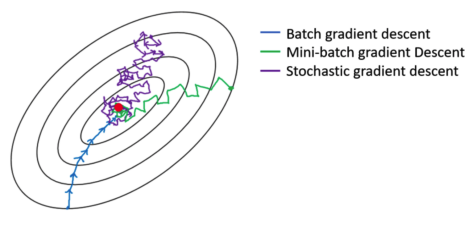

In [17]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_sc, y_train)
prediction = model.predict(X_test_sc)
print('MSE for OLS:', mean_squared_error(y_test, prediction))

MSE for OLS: 28.83620312219271


In [18]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5,    # number of chunks to split the data
              shuffle=True, 
              random_state=0)

In [19]:
print("Cross-validation train scores for OLS:\n{}".format(cross_validate(model, 
                                                  X_train_sc, y_train, 
                                                  cv = kfold, 
                                                 scoring = 'neg_mean_squared_error',
                                                 return_train_score = True)['train_score']))

Cross-validation train scores for OLS:
[-21.71562281 -22.5866669  -20.72107618 -17.64548183 -18.98702343]


<a id="reg"></a>
## 2. Regularization

Зачастую модель обучается на каких-то зашумленных данных. Веса модели после обучения подбираются для уменьшения ошибки целевой функции. От различных выборках модель может обучаться по-разному, но нам бы хотелось вычленять основную зависимость примерно одинаково, то есть **не переобучаться (overfit)** на данных. Иначе обучившись на одном сете, мы можем получать неожиданный результат на других данных.

То есть мы хотели бы штрафовать модель за ее сложность, чтобы выискивать более простые зависимости.


Еще одной проблемой, специфичной для линейных моделей, является **мультиколлинеарность**. Особенность мультиколлинеарности заключается в том, что из-за того, что решений становится бесконечно много, коэффициенты модели могут принимать огромные значения. Отсюда вывод: необходимо каким-то образом ограничить величину коэффициентов модели.

Для линейной модели дополнительные ограничения на веса выполняют роль регуляризации. Различают:
- $l_1$-регуляризацию (LASSO, least absolute shrinkage and selection operator), учитывание $||w||_1$ 
- $l_2$-регуляризацию (Ridge), учитывание $||w||^2_2$
- Elastic net - комбинация двух предыдущих (учитываются обе нормы весов)

### Ridge and Lasso

* Ridge]
    * cannot get betas to exactly zero, but will limit how much they go away from zero, thus decreasing variance (but increasing bias)

<img src=https://miro.medium.com/max/4800/1*hAGhQehrqAmT1pvz3q4t8Q.png width="500">


* Lasso
    * can get some betas to be exactly zero, so you not only get regularisation, you also get feature selection

<img src=https://miro.medium.com/max/4800/1*P5Lq5mAi4WAch7oIeiS3WA.png width="500">

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor

In [23]:
model_2 = SGDRegressor(loss = 'squared_loss', penalty = 'l2')


parameters = {'alpha': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2] }

sv = GridSearchCV(model_2, 
                  parameters, 
                  cv = kfold,
                  scoring = 'neg_mean_squared_error', 
                  return_train_score = True)

In [24]:
sv.fit(X_train_sc, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SGDRegressor(loss='squared_loss'),
             param_grid={'alpha': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [25]:
print("Neg MSE on test set:", sv.score(X_test_sc, y_test))

Neg MSE on test set: -33.13986110402352


In [26]:
print("Best parameters:", sv.best_params_)
print("Best cross-validation score:", sv.best_score_)

Best parameters: {'alpha': 1e-05}
Best cross-validation score: -24.3055268630433


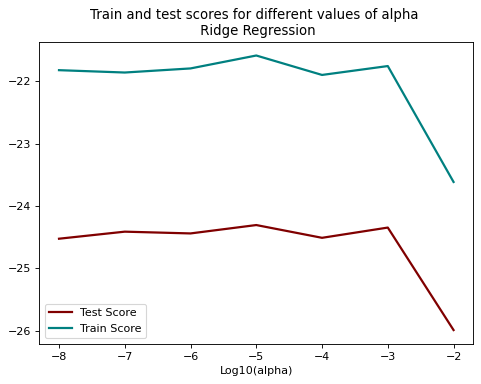

In [27]:
cv_results = pd.DataFrame(sv.cv_results_)

plt.figure(figsize = (7, 5), dpi = 80)
plt.title('Train and test scores for different values of alpha \n Ridge Regression')

sns.lineplot(np.log10(cv_results['param_alpha'].astype(float)), cv_results['mean_test_score'], 
             color = 'maroon', lw = 2, label = 'Test Score')
sns.lineplot(np.log10(cv_results['param_alpha'].astype(float)), cv_results['mean_train_score'], 
             color = 'teal', lw = 2, label = 'Train Score')

plt.ylabel('')
plt.xlabel('Log10(alpha)')
plt.legend()
plt.show()